# Data Preperation

Task: You have been provided with a historical dataset of taxi data – which can be assumed to be a good approximation of ride-hailing data - from Chicago, USA.
Select the year(s) that have been assigned to you and clean your dataset for use in later stages of your project. As the CSV file might be too large for your computer to open it with Python, you could preprocess the file first with tools like “sed” or “xsv” in order to filter out not needed rows and columns. To obtain hourly weather data, access the links provided above (or reach out to us). Also, provide a detailed description of the trip dataset such that there are no pending questions. Due to privacy reasons, spatial data is given only on census tract level. To better analyze location data – specifically in lower dimensions - further discretize the city in scope with the help of suitable tools (such as a matrix of hexagons using h3-Uber). This discretization is crucial for the analysis of the spatial resolution. Furthermore, you should also consider different temporal discretization (e.g., hourly, 4-hourly, daily) etc.

**In this file we will make final preparations to the dataset. First we will test the taxi data on null values and remove them if deemed necessary. For this we will test how much data will be affected and only small changes will be executed. Following this we will combine each line of the Taxi dataframe with hourly weather data for chicago. Concluding we will create aggregations of this dataset regarding different discretations**

### Data preperation of Taxi Data

In [2]:
# importing the libraries
import numpy as np #?
import pandas as pd
import matplotlib.pyplot as plt #?
import folium
import h3
import h3pandas
import geopandas as gpd

In [3]:
file_path = "./data/"
taxi = pd.read_csv(f"{file_path}chicago_taxi_2021.csv") #parse_dates sometimes resulted in the timestamps not converting correctly
taxi = taxi.astype({'trip_start_timestamp': 'datetime64[ns]', 'trip_end_timestamp': 'datetime64[ns]'})

In [4]:
# taking a look at the taxi data
print("number of rows in taxi data:", len(taxi))
taxi.head(10)

number of rows in taxi data: 3753630


,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,trip_total,company,payment_type
0,02fc5d8c3e8525a49b7514bd6c2b3301c2d6aa79,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2021-01-01,2021-01-01 00:15:00,NaN,NaN,NaN,4.0,1021.0,3.17,13.25,Flash Cab,Cash
1,33eb5c7a1439ac1e3ec6d1520e21db8137d1d11b,2c508057a94474215bdea7b101edad0dc911ef61bb99e6...,2021-01-01,2021-01-01 15:30:00,NaN,NaN,56.0,NaN,56047.0,7.10,27.00,Flash Cab,Cash
2,4bcfcfa78f372b705214ee2cba9c765ad6ba5161,31261f6e7fc645eff98c7964c7ea71a0ea7e387a6bd7f8...,2021-01-01,2021-01-01 00:00:00,NaN,NaN,8.0,8.0,120.0,0.10,4.50,Taxi Affiliation Services,Cash
3,655bbd9bcb0a78ee003e304ebbe350b21cdd7083,f6138aa35e1fb074eb79fbe29f512b6153dca3593d8cd2...,2021-01-01,2021-01-01 00:00:00,NaN,NaN,67.0,67.0,0.0,0.00,3.25,"Taxicab Insurance Agency, LLC",Cash
4,7b7b8108de94a518607068a7369ceea1ab2ae924,2c508057a94474215bdea7b101edad0dc911ef61bb99e6...,2021-01-01,2021-01-01 00:00:00,NaN,NaN,60.0,31.0,50.0,0.38,4.00,Flash Cab,Cash
5,820a917a49280f0ee5ba61802ae5d13c55bf51ed,7476a493f34aa1075570e89104cdaf3aaf5c0fd4679382...,2021-01-01,2021-01-01 00:15:00,NaN,NaN,33.0,NaN,960.0,10.60,28.00,Taxi Affiliation Services,Cash
6,855259d1bc129f6370f038aa910067972eeae037,0aba795cd29b34ff868043bc923a341f37c4f6d7afabe4...,2021-01-01,2021-01-01 00:15:00,NaN,NaN,28.0,22.0,900.0,0.30,18.25,Taxi Affiliation Services,Cash
7,88194fab0a0a28df1b87e9f358143197d004d4d9,e11ecc8e74a2d3cbd2e9f58151ed09c81587cb491c50f6...,2021-01-01,2021-01-01 00:15:00,NaN,NaN,6.0,4.0,1140.0,4.30,15.25,Taxi Affiliation Services,Cash
8,a76c9cae097af5ff1dfef35b376a832f54d789ea,72920f6ebc5830d39039323cf78a316085444eb8f8b272...,2021-01-01,2021-01-01 00:30:00,NaN,NaN,8.0,68.0,1800.0,9.80,29.00,Taxi Affiliation Services,Cash
9,cc63c100ae898753ac347598b23128cc11f51948,b24a8d63c6b52037985d5b14a25f034184f923f5313430...,2021-01-01,2021-01-01 00:00:00,NaN,NaN,76.0,76.0,240.0,0.10,10.75,Top Cab Affiliation,Cash


In [5]:
#Test on Null values
taxi.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3753630 entries, 0 to 3753629
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   trip_id                 3753630 non-null  object        
 1   taxi_id                 3753617 non-null  object        
 2   trip_start_timestamp    3753630 non-null  datetime64[ns]
 3   trip_end_timestamp      3753630 non-null  datetime64[ns]
 4   pickup_census_tract     1141408 non-null  float64       
 5   dropoff_census_tract    1127133 non-null  float64       
 6   pickup_community_area   3638372 non-null  float64       
 7   dropoff_community_area  3483235 non-null  float64       
 8   trip_seconds            3753046 non-null  float64       
 9   trip_miles              3753126 non-null  float64       
 10  trip_total              3753106 non-null  float64       
 11  company                 3753630 non-null  object        
 12  payment_type  

The following is a brief explanation of the features of our tripdata. We have already removed all features that are neither relevant for the predictions nor the descriptive analysis
1. trip_id - unique identifier for each trip, which we will  not use, need since its more convienient to just juste the normal row number and after aggregating it will have no use anyway
2. taxi_id - id of one unique taxi, which will have no use anyway after aggregating 
3. trip_start_timestamp & trip_end_timestamp - starting and end time of a trip down to a 15 minute timemark
4. pickup_census_tract & dropoff_census_tract - census tract areas, defined by the US Census Bureau, of the start and end geo location of each trip. For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.
5. pickup_community_area & dropoff_community_area - community area in which the start and end points of each trip was located. Chicago is split into 77 community areas. This column often will be blank for locations outside Chicago.
6. trip_seconds - Duration of the trip in seconds.
7. trip_miles - Distance of a trip in miles.
8. trip_total - Total cost a trip
9. company - Taxi company of the taxi used in the trip
10. payment_type - Payment type used

Most missing values are geodata, with census_tract being null in more than 2 million data rows. Description of the census_tract datacolumns from the city of Chicago: 
"The Census Tract where the trip began/ended. For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago". This explains the huge Null value rate. We choose to keep the census tract, as well as th communty_area features regardless of their Null procentage, but we will still have a look this procentage

In [6]:
#Rows missing any Value other than Geodata
print("Lines with wrong Year:", len(taxi[(taxi["trip_start_timestamp"].dt.year != 2021)|(taxi["trip_end_timestamp"].dt.year != 2021)]))
print("Lines with Duplicates:", len(taxi)-len(taxi.drop_duplicates()))
print("Lines with all Null Values:", len(taxi) - len(taxi.dropna(axis=0, how= 'all')))
print("Lines with any Null Values:", len(taxi) - len(taxi.dropna(axis=0, how= 'any')))
print("Lines missing at least one value non Geodata:", len(taxi[(taxi["taxi_id"].isna()|taxi["trip_seconds"].isna()|taxi["trip_miles"].isna()|taxi["trip_total"].isna())]))
print("Procentage of these non Geodata Null values compared to the whole", (len(taxi[(taxi["taxi_id"].isna()|taxi["trip_seconds"].isna()|taxi["trip_miles"].isna()|taxi["trip_total"].isna())])/len(taxi))*100, "%")
print("Procentage of any null values in community_area data:", (len(taxi[(taxi["pickup_community_area"].isna()|taxi["dropoff_community_area"].isna())])/len(taxi))*100, "%")
print("Procentage of any null values in census_tract data:", (len(taxi[(taxi["pickup_census_tract"].isna()|taxi["dropoff_census_tract"].isna())])/len(taxi))*100, "%")

Lines with wrong Year: 0
Lines with Duplicates: 0
Lines with all Null Values: 0
Lines with any Null Values: 2683507
Lines missing at least one value non Geodata: 1585
Procentage of these non Geodata Null values compared to the whole 0.04222579209991395 %
Procentage of any null values in community_area data: 10.274134637670734 %
Procentage of any null values in census_tract data: 71.09150342468492 %


Since there are only 0,05% of all rows with missing trip related features, removing them will not be significant fo our data quality. But there are 10% of all data that is atleast missing one geofeature, and there are 70% missing census tract assignment. So to work with geodata, specifically the smaller census areas, there would need to be a lot of data sacrificed.

In [7]:
#Remove Null values outside of geodata
taxi = taxi[~(taxi["taxi_id"].isna()|taxi["trip_seconds"].isna()|taxi["trip_miles"].isna()|taxi["trip_total"].isna())]
taxi.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3752045 entries, 0 to 3753629
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   trip_id                 3752045 non-null  object        
 1   taxi_id                 3752045 non-null  object        
 2   trip_start_timestamp    3752045 non-null  datetime64[ns]
 3   trip_end_timestamp      3752045 non-null  datetime64[ns]
 4   pickup_census_tract     1141040 non-null  float64       
 5   dropoff_census_tract    1126764 non-null  float64       
 6   pickup_community_area   3636870 non-null  float64       
 7   dropoff_community_area  3481765 non-null  float64       
 8   trip_seconds            3752045 non-null  float64       
 9   trip_miles              3752045 non-null  float64       
 10  trip_total              3752045 non-null  float64       
 11  company                 3752045 non-null  object        
 12  payment_type  

In [8]:
taxi.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,trip_total
count,1141040.00,1126764.00,3636870.00,3481765.00,3752045.00,3752045.00,3752045.00
mean,17031456496.06,17031393579.30,31.93,25.79,1143.00,5.63,24.56
std,369984.09,340629.58,25.04,20.93,1811.87,9.97,73.35
min,17031010100.00,17031010100.00,1.00,1.00,0.00,0.00,0.00
25%,17031081500.00,17031081403.00,8.00,8.00,420.00,0.70,8.75
50%,17031320100.00,17031320100.00,28.00,25.00,840.00,2.30,16.00
75%,17031839100.00,17031839000.00,44.00,33.00,1560.00,9.80,32.00
max,17031980100.00,17031980100.00,77.00,77.00,86340.00,3430.53,9900.30


It seems there are still some outliers that have to be removed. Specifically trip_seconds, trip_miles and trip_total have max vaules that are much higher than their 75% quantil. We can even see that their std have been moved up tremendously by these outliers. We will set logical boundaries for each of these featues; We will not further examine trips over 2 hours, since there really isnt a need for longer trips in a town, except for roundtrips. We will therefore also not look at trips with trip_miles over 31 which is roughly 50 km and a estimation of mean driving speed, as well as a trip_total over 100.

In [9]:
print("Procentage of outliers", (len(taxi[((taxi["trip_seconds"]>=(7200))|(taxi["trip_miles"]>=(31))|(taxi["trip_total"]>=(100)))])/len(taxi))*100, "%")
taxi = taxi[~((taxi["trip_seconds"]>=(7200))|(taxi["trip_miles"]>=(31))|(taxi["trip_total"]>=(100)))]
taxi.describe().apply(lambda s: s.apply('{0:.2f}'.format))

Procentage of outliers 1.0109686850770712 %


,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,trip_total
count,1122586.00,1122023.00,3601311.00,3466025.00,3714113.00,3714113.00,3714113.00
mean,17031449161.15,17031392256.01,31.67,25.71,1074.16,5.39,22.84
std,367295.84,339882.00,24.90,20.86,869.82,6.17,18.14
min,17031010100.00,17031010100.00,1.00,1.00,0.00,0.00,0.00
25%,17031081500.00,17031081403.00,8.00,8.00,420.00,0.70,8.75
50%,17031320100.00,17031320100.00,28.00,25.00,836.00,2.27,15.75
75%,17031839100.00,17031838200.00,44.00,33.00,1551.00,9.60,31.50
max,17031980100.00,17031980100.00,77.00,77.00,7199.00,30.99,99.90


### Data preperation of weather data / inserting weather data

#### 2021 Weather Data

Using weather data from 2016 to predict something in 2021 can result in inaccuracies, as weather patterns and conditions can vary significantly from year to year. Therefore, it is essential to use the most up-to-date weather data available to make accurate predictions.

If you use weather data from 2016, your model may not capture the variations in weather patterns that have occurred in the intervening years, which could lead to incorrect predictions. Additionally, using outdated data could result in incorrect cause-and-effect relationships, as factors that were significant in 2016 may not be as relevant in 2021.

**NASA/POWER CERES/MERRA2 Native Resolution Hourly Data**

Benefits of using NASA/POWER hourly weather data:
* many additional climate values are selectable
* location of most fleet usage can be selected, resulting in having more accurate weather data

**POWER Hourly API Request**

In [19]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
url= "https://power.larc.nasa.gov/api/temporal/hourly/point?Time=LST&parameters=T2M,PRECTOTCORR,WS50M&community=RE&longitude=-87.6521&latitude=41.8831&start=20210101&end=20220101&format=JSON"

response = requests.get(url)

if response.status_code == 200:
    print("The request was successful")
else:
    print("Error retrieving data from API")

data = response.json()

# extract the data and convert to DataFrame
weather_df = pd.DataFrame.from_dict(data["properties"]["parameter"], orient="columns")

# convert the index to a datetime format
weather_df.index = pd.to_datetime(weather_df.index, format="%Y%m%d%H")

# order the datetimes in ascending order
weather_df = weather_df.sort_index(ascending=True)

# rename the columns
weather_df = weather_df.rename(columns={"T2M": "temp_2m", "PRECTOTCORR": "precip", "WS50M": "windspeed_50m"})

# display the DataFrame
weather_df.head()

The request was successful


,temp_2m,precip,windspeed_50m
2020-12-31 18:00:00,-2.24,0.0,1.12
2020-12-31 19:00:00,-2.14,0.0,2.14
2020-12-31 20:00:00,-1.89,0.0,3.62
2020-12-31 21:00:00,-1.63,0.0,4.75
2020-12-31 22:00:00,-1.45,0.0,5.49


In [21]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-12-31 18:00:00 to 2022-01-01 17:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp_2m        8784 non-null   float64
 1   precip         8784 non-null   float64
 2   windspeed_50m  8784 non-null   float64
dtypes: float64(3)
memory usage: 274.5 KB


**Filtering the Year 2021**

In [22]:
# filter the year 2021
weather_df = weather_df.loc['2021-01-01':'2021-12-31']

In [23]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2021-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp_2m        8760 non-null   float64
 1   precip         8760 non-null   float64
 2   windspeed_50m  8760 non-null   float64
dtypes: float64(3)
memory usage: 273.8 KB


In [24]:
weather_df.index.unique()

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 01:00:00',
               '2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               ...
               '2021-12-31 14:00:00', '2021-12-31 15:00:00',
               '2021-12-31 16:00:00', '2021-12-31 17:00:00',
               '2021-12-31 18:00:00', '2021-12-31 19:00:00',
               '2021-12-31 20:00:00', '2021-12-31 21:00:00',
               '2021-12-31 22:00:00', '2021-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq=None)

**=> the dataset now consists of every hour of the year 2021**

In [25]:
# convert precipitation (mm/hr) to a binary variable indicating whether it rained or not, with the threshold value 0.5 mm/hr
# weather_df['precip'] = (weather_df['precip'] > 0.5).astype(int)

In [26]:
weather_df.head(24)

,temp_2m,precip,windspeed_50m
2021-01-01 00:00:00,-1.33,0.00,6.35
2021-01-01 01:00:00,-1.28,0.00,7.12
2021-01-01 02:00:00,-1.31,0.00,7.48
2021-01-01 03:00:00,-1.16,0.00,7.30
2021-01-01 04:00:00,-0.98,0.00,7.33
2021-01-01 05:00:00,-0.77,0.00,8.15
2021-01-01 06:00:00,-0.31,0.00,9.86
2021-01-01 07:00:00,-0.07,0.00,10.21
2021-01-01 08:00:00,0.14,0.00,10.74
2021-01-01 09:00:00,0.13,0.01,10.97


#### Weather Data Validation

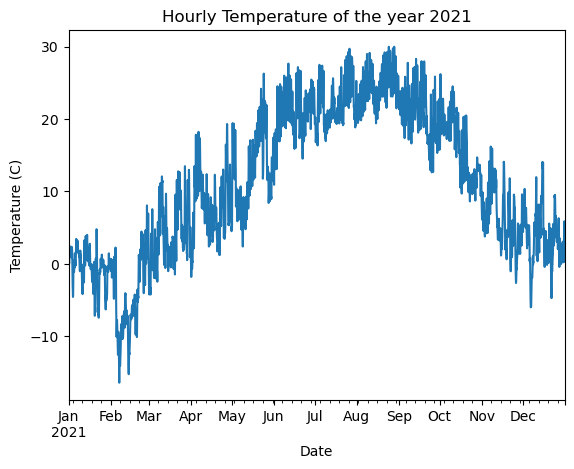

In [27]:
# plot the temperature data
weather_df["temp_2m"].plot()
plt.title("Hourly Temperature of the year 2021")
plt.xlabel("Date")
plt.ylabel("Temperature (C)")
plt.show()

**Reference data from the Team Assignment document:**
* NOAA Online Weather Data: https://www.weather.gov/wrh/climate?wfo=lot

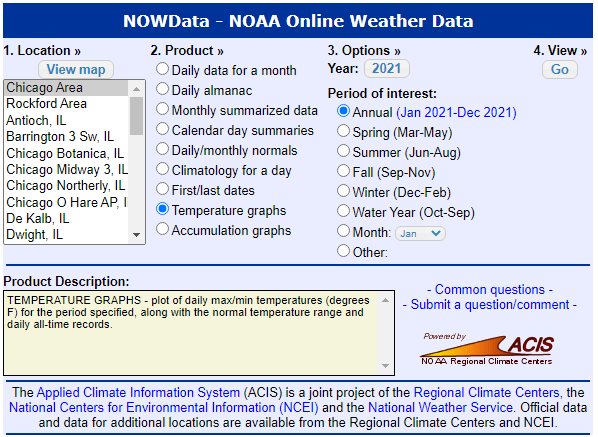    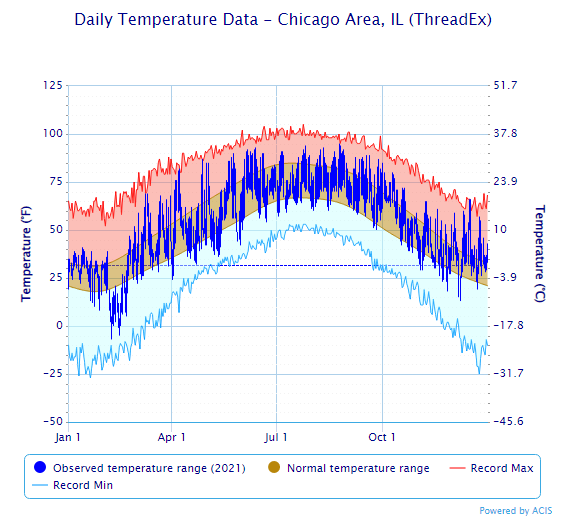


**=> the temperature graphs of both sources are very similar, so I assume that the source "NASA/POWER CERES/MERRA2 Native Resolution Hourly Data" provides valid data**



**For comparison, you can also see the temperature curve for 2016 here:**

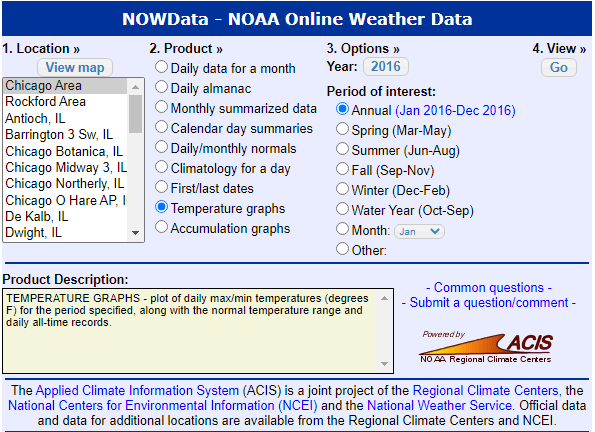      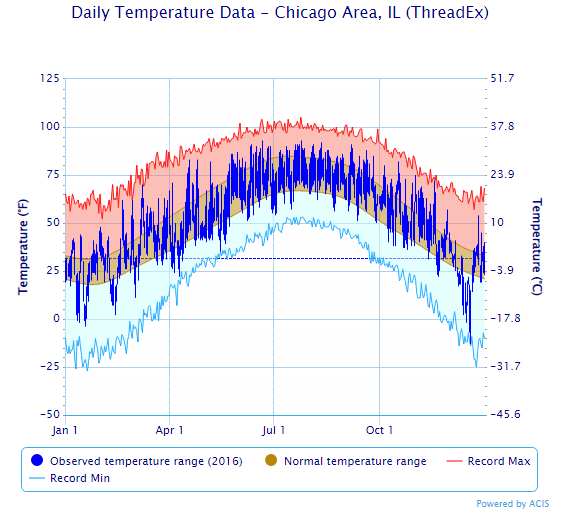

**=> Therefore, it is not advisable to use weather data from 2016 to make predictions for 2021, as there is variation in temperature data between the two years.**

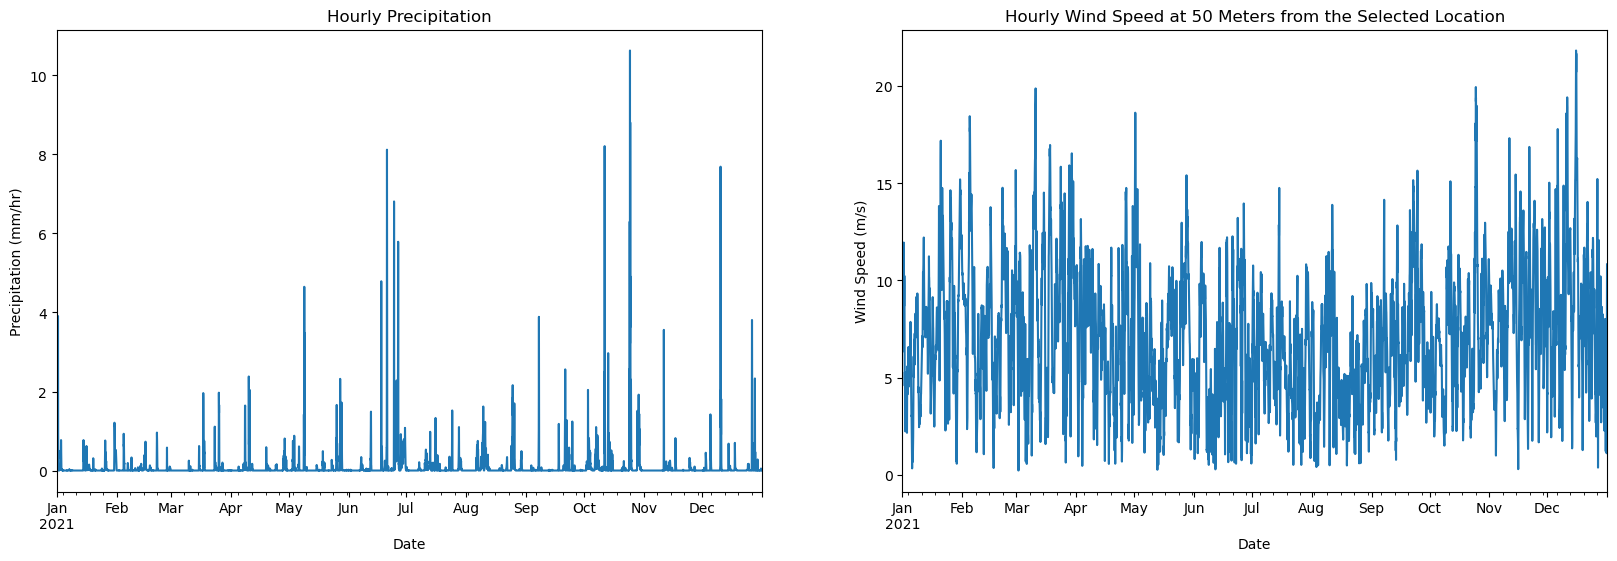

In [40]:
# create a figure with two subplots using pandas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6), sharex=False)

# plot the precipitation data in the first subplot
weather_df.plot(y='precip', ax=axes[0], legend=False)
axes[0].set_title('Hourly Precipitation')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Precipitation (mm/hr)')

# plot the wind speed data in the second subplot
weather_df.plot(y='windspeed_50m', ax=axes[1], legend=False)
axes[1].set_title('Hourly Wind Speed at 50 Meters from the Selected Location')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Wind Speed (m/s)')

plt.show()

In the following section we will add weather data exported from the NASA API to our trip data

#### Inserting Weather Data

In [10]:
weather_df = pd.read_csv(f"{file_path}chicago_weather_2021.csv", parse_dates=["date"])

In [11]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           8760 non-null   datetime64[ns]
 1   temp_2m        8760 non-null   float64       
 2   precip         8760 non-null   int64         
 3   windspeed_50m  8760 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 273.9 KB


In [12]:
weather_df.head(3)

,date,temp_2m,precip,windspeed_50m
0,2021-01-01 00:00:00,-1.33,0,6.35
1,2021-01-01 01:00:00,-1.28,0,7.12
2,2021-01-01 02:00:00,-1.31,0,7.48


Now we will merge the weather data per hour first on the start timestamp and in a second run on the end timestamp. We will use merge_asof which will merge the weather dates on the last line in weatherdata that is less than or equal to the selected row in taxi timestamp (since every value under the full hour is greater than the last full hour every hourly value will be assigned to the correct hour)

In [13]:
taxi = pd.merge_asof(taxi, weather_df, left_on=["trip_start_timestamp"], right_on=["date"])
taxi.drop_duplicates(subset=["trip_start_timestamp"]).sort_values(by=["trip_start_timestamp"]).head(5)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,trip_total,company,payment_type,date,temp_2m,precip,windspeed_50m
0,02fc5d8c3e8525a49b7514bd6c2b3301c2d6aa79,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2021-01-01 00:00:00,2021-01-01 00:15:00,NaN,NaN,NaN,4.0,1021.0,3.17,13.25,Flash Cab,Cash,2021-01-01 00:00:00,-1.33,0,6.35
23,3e1ac82501797e2e6cd020d2eb6a47774add503f,51e37146cd6467734e50a00ffe2ebbb77ee35e5f207817...,2021-01-01 00:15:00,2021-01-01 00:30:00,NaN,NaN,28.0,6.0,1140.0,6.40,25.35,Medallion Leasin,Credit Card,2021-01-01 00:00:00,-1.33,0,6.35
45,098966cb7c9bcc2205519aea528f6b753a4f2128,26a53f41b40ca4ec225a15ff55054c0a2d9e4a48341ce9...,2021-01-01 00:30:00,2021-01-01 00:45:00,NaN,NaN,6.0,14.0,1020.0,0.00,17.50,Taxi Affiliation Services,Cash,2021-01-01 00:00:00,-1.33,0,6.35
66,0e9a2f1ceee74bcda947a61c92ad6ced3b2822eb,31261f6e7fc645eff98c7964c7ea71a0ea7e387a6bd7f8...,2021-01-01 00:45:00,2021-01-01 01:00:00,NaN,NaN,28.0,44.0,1260.0,10.50,28.50,Taxi Affiliation Services,Cash,2021-01-01 00:00:00,-1.33,0,6.35
82,0472813b2adc49432007444d585556472f1ae04b,175a58299af3a8c883453259b9a0cfc45ccbbbe1a07883...,2021-01-01 01:00:00,2021-01-01 01:15:00,NaN,NaN,8.0,32.0,574.0,1.40,12.00,Medallion Leasin,Credit Card,2021-01-01 01:00:00,-1.28,0,7.12


In [14]:
#drop unnecessary column, rename and resort
taxi.drop(["date"], axis=1, inplace=True)
taxi.rename(columns={"temp_2m": "start_temp", "precip": "start_precip", "windspeed_50m": "start_windspeed"}, inplace=True)
taxi.sort_values(by=["trip_end_timestamp"], inplace=True)

In [15]:
taxi = pd.merge_asof(taxi, weather_df, left_on=["trip_end_timestamp"], right_on=["date"])
taxi.drop_duplicates(subset=["trip_start_timestamp"]).sort_values(by=["trip_start_timestamp"]).head(5)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,trip_total,company,payment_type,start_temp,start_precip,start_windspeed,date,temp_2m,precip,windspeed_50m
0,505af6c6eb3cc5b3098f9c565af55e7ef6397d94,175a58299af3a8c883453259b9a0cfc45ccbbbe1a07883...,2021-01-01 00:00:00,2021-01-01 00:00:00,NaN,NaN,8.0,8.0,165.0,0.3,5.00,Medallion Leasin,Cash,-1.33,0,6.35,2021-01-01 00:00:00,-1.33,0,6.35
10,3276bc172c61ea58ce803d2f34611f6c074c14f1,35057a271731c5b976bda25efe85aa0c1901d0a5fc9ba2...,2021-01-01 00:15:00,2021-01-01 00:15:00,NaN,NaN,8.0,8.0,0.0,0.0,25.03,Chicago Independents,Credit Card,-1.33,0,6.35,2021-01-01 00:00:00,-1.33,0,6.35
23,901982148ffc2f8fe4846a0cfd645239993b88c4,342474dd3a24c9d5b7dbc2514032a01ecb396624638be5...,2021-01-01 00:30:00,2021-01-01 00:30:00,NaN,NaN,8.0,8.0,180.0,0.5,5.50,Taxi Affiliation Services,Cash,-1.33,0,6.35,2021-01-01 00:00:00,-1.33,0,6.35
48,b3403c3d4460d34241cd998c81395aea1de9e16a,175a58299af3a8c883453259b9a0cfc45ccbbbe1a07883...,2021-01-01 00:45:00,2021-01-01 00:45:00,NaN,NaN,8.0,28.0,590.0,3.1,11.75,Medallion Leasin,Cash,-1.33,0,6.35,2021-01-01 00:00:00,-1.33,0,6.35
64,983177225eb98bf27fecb1dfd88401b604c0454a,3665a72ee495b03f4dae72307dc6e5e58e21518f77d8e6...,2021-01-01 01:00:00,2021-01-01 01:00:00,NaN,NaN,16.0,15.0,480.0,2.1,8.50,Taxi Affiliation Services,Cash,-1.28,0,7.12,2021-01-01 01:00:00,-1.28,0,7.12


In [16]:
taxi.drop(["date"], axis=1, inplace=True)
taxi.rename(columns={"temp_2m": "end_temp", "precip": "end_precip", "windspeed_50m": "end_windspeed"}, inplace=True)
taxi.sort_values(by=["trip_start_timestamp"], inplace=True)

In [17]:
taxi.head(3)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,trip_total,company,payment_type,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed
0,505af6c6eb3cc5b3098f9c565af55e7ef6397d94,175a58299af3a8c883453259b9a0cfc45ccbbbe1a07883...,2021-01-01,2021-01-01 00:00:00,NaN,NaN,8.0,8.0,165.0,0.30,5.0,Medallion Leasin,Cash,-1.33,0,6.35,-1.33,0,6.35
63,b6a1c6f16a7f52cdfed0476891b7c8d58440011c,931225a382fc38a75212f9d358439aec0d9b50fdaf32ad...,2021-01-01,2021-01-01 00:45:00,NaN,NaN,14.0,22.0,2361.0,9.05,28.0,Flash Cab,Prcard,-1.33,0,6.35,-1.33,0,6.35
37,a76c9cae097af5ff1dfef35b376a832f54d789ea,72920f6ebc5830d39039323cf78a316085444eb8f8b272...,2021-01-01,2021-01-01 00:30:00,NaN,NaN,8.0,68.0,1800.0,9.80,29.0,Taxi Affiliation Services,Cash,-1.33,0,6.35,-1.33,0,6.35


## Add geographical information

Up until now, our geographic regions are limited to the center of either the designated community areas or the census tracts. This is not optimal for two reasons.

First reason is that the centers of these areas are confusing and not that easy to differentiate on a map. The second reason is that these regions are usually different sizes and are therefore not directly comparable.  

This can easily be visualized by first loading in the centroid data and visualizing it on a map of Chicago

In [18]:
community_centroids = pd.read_csv(f"{file_path}chicago_community_centroid.csv")
marker_map = folium.Map(location=[41.9, -87.6], zoom_start=10)
for centroid in community_centroids.values:
    folium.Marker(location=[centroid[2], centroid[3]], fill_color='blue').add_to(marker_map)
marker_map

To address the first point, we move away from the centroid data and load in polygon data stored in a geojson file for Chicago, which allows us to plot the actual community areas and census tracts and not just their centroids.

<Axes: >

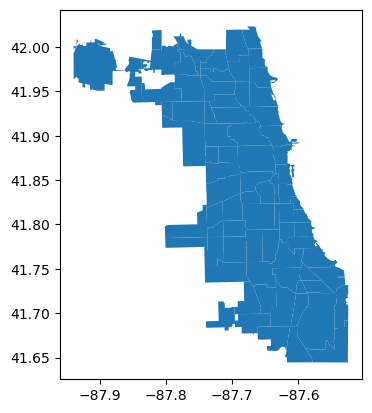

In [19]:
community_areas_geojson = gpd.read_file(f"{file_path}chicago_community_areas.geojson")
community_areas_geojson.plot()

<Axes: >

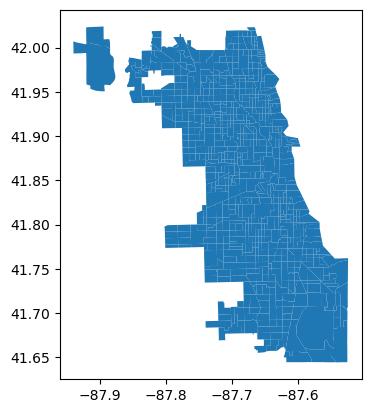

In [20]:
census_tracts_geojson = gpd.read_file(f"{file_path}chicago_census_tracts.geojson")
census_tracts_geojson.plot()

Such geographical information is encoded in the geometry column of this geopandas DataFrame, as can be seen here:

In [21]:
community_areas_geojson.head(5)

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


In [ ]:
census_tracts_geojson.head(5)

We then add this geographical information to the community centroid dataframe

In [22]:
community_centroids

,Community_Area,Census_tract,Latitude,Longitude
0,1.0,NaN,42.009623,-87.670167
1,2.0,NaN,42.001571,-87.695013
2,3.0,NaN,41.965812,-87.655879
3,4.0,NaN,41.975171,-87.687516
4,5.0,NaN,41.947792,-87.683835
...,...,...,...,...
547,NaN,1.703184e+10,41.806765,-87.608949
548,NaN,1.703184e+10,41.944814,-87.690775
549,NaN,1.703184e+10,41.776164,-87.579948
550,NaN,1.703198e+10,41.979071,-87.903040


In [23]:
geographic_data = community_centroids.merge(right=census_tracts_geojson.astype({"geoid10" : "float"})[["geoid10", "geometry"]], how="left", left_on="Census_tract", right_on="geoid10")
geographic_data.update(community_centroids.merge(right=community_areas_geojson.astype({"area_num_1" : "float"}), how="left", left_on="Community_Area", right_on="area_num_1"),)
geographic_data.drop("geoid10", axis=1, inplace=True)
geographic_data

,Community_Area,Census_tract,Latitude,Longitude,geometry
0,1.0,NaN,42.009623,-87.670167,MULTIPOLYGON (((-87.65455590025104 41.99816614...
1,2.0,NaN,42.001571,-87.695013,MULTIPOLYGON (((-87.6846530946559 42.019484772...
2,3.0,NaN,41.965812,-87.655879,MULTIPOLYGON (((-87.64102430213292 41.95480280...
3,4.0,NaN,41.975171,-87.687516,MULTIPOLYGON (((-87.6744075678037 41.976103404...
4,5.0,NaN,41.947792,-87.683835,MULTIPOLYGON (((-87.67336415409336 41.93234274...
...,...,...,...,...,...
547,NaN,1.703184e+10,41.806765,-87.608949,MULTIPOLYGON (((-87.61128600000754 41.80216899...
548,NaN,1.703184e+10,41.944814,-87.690775,MULTIPOLYGON (((-87.69666899996376 41.94854100...
549,NaN,1.703184e+10,41.776164,-87.579948,MULTIPOLYGON (((-87.55868599996295 41.77379199...
550,NaN,1.703198e+10,41.979071,-87.903040,MULTIPOLYGON (((-87.92062799997296 42.00453199...


Now that we have added the geographic information about both community areas and census tracts, we can work much better with this data later.

One problem remaining, however, is that both of those regions are not uniform in size and are therefore not really good for accurate comparisons. 

A much better solution for this would be to use a hexagonal grid, which aggregates the trips inside each hexagon. The advantages are that each hexagon is the same size and the distance from each hexagon center to the next is always the same, allowing for much better comparability.

For this task, we use the h3 library developed by Uber.
From our centroid data, we can take the latitude and longitude of each community and census tract area and assign it to a h3 hexagon, which is designated by a hexadecimal code.

In [24]:
geographic_data["h3_6"] = geographic_data.apply(lambda x: h3.geo_to_h3(x.Latitude, x.Longitude, resolution=6), axis=1)
geographic_data["h3_7"] = geographic_data.apply(lambda x: h3.geo_to_h3(x.Latitude, x.Longitude, resolution=7), axis=1)
geographic_data["h3_8"] = geographic_data.apply(lambda x: h3.geo_to_h3(x.Latitude, x.Longitude, resolution=8), axis=1)
geographic_data

,Community_Area,Census_tract,Latitude,Longitude,geometry,h3_6,h3_7,h3_8
0,1.0,NaN,42.009623,-87.670167,MULTIPOLYGON (((-87.65455590025104 41.99816614...,862664d8fffffff,872664d8cffffff,882664d8cdfffff
1,2.0,NaN,42.001571,-87.695013,MULTIPOLYGON (((-87.6846530946559 42.019484772...,862664d8fffffff,872664d8effffff,882664d8e1fffff
2,3.0,NaN,41.965812,-87.655879,MULTIPOLYGON (((-87.64102430213292 41.95480280...,862664d8fffffff,872664d89ffffff,882664d897fffff
3,4.0,NaN,41.975171,-87.687516,MULTIPOLYGON (((-87.6744075678037 41.976103404...,862664d8fffffff,872664d8affffff,882664d8bdfffff
4,5.0,NaN,41.947792,-87.683835,MULTIPOLYGON (((-87.67336415409336 41.93234274...,862664ca7ffffff,872664ca5ffffff,882664ca59fffff
...,...,...,...,...,...,...,...,...
547,NaN,1.703184e+10,41.806765,-87.608949,MULTIPOLYGON (((-87.61128600000754 41.80216899...,862664cc7ffffff,872664cc4ffffff,882664cc49fffff
548,NaN,1.703184e+10,41.944814,-87.690775,MULTIPOLYGON (((-87.69666899996376 41.94854100...,862664ca7ffffff,872664ca5ffffff,882664ca51fffff
549,NaN,1.703184e+10,41.776164,-87.579948,MULTIPOLYGON (((-87.55868599996295 41.77379199...,862664cc7ffffff,872664ceaffffff,882664cc53fffff
550,NaN,1.703198e+10,41.979071,-87.903040,MULTIPOLYGON (((-87.92062799997296 42.00453199...,862759347ffffff,87275934effffff,88275934edfffff


H3 provides hexagonal grids in different resolutions, so we look at some of them to evaluate based on how many centroids each hexagon includes.

First, however, the data for each resolution needs to be grouped by the h3 index and converted to a geodataframe for easy plotting

In [25]:
h3_centroids = geographic_data.copy()
h3_centroids["h3_6_count"] = geographic_data["h3_6"]
h3_centroids["h3_7_count"] = geographic_data["h3_7"]
h3_centroids["h3_8_count"] = geographic_data["h3_8"]
h3_centroids_6 = h3_centroids.groupby("h3_6").count()
h3_centroids_7 = h3_centroids.groupby("h3_7").count()
h3_centroids_8 = h3_centroids.groupby("h3_8").count()
h3_centroids_geo_6 = pd.DataFrame(h3_centroids_6).h3.h3_to_geo_boundary()
h3_centroids_geo_7 = pd.DataFrame(h3_centroids_7).h3.h3_to_geo_boundary()
h3_centroids_geo_8 = pd.DataFrame(h3_centroids_8).h3.h3_to_geo_boundary()
h3_centroids_geo_6["index"] = h3_centroids_geo_6.reset_index().index
h3_centroids_geo_7["index"] = h3_centroids_geo_7.reset_index().index
h3_centroids_geo_8["index"] = h3_centroids_geo_8.reset_index().index
h3_centroids_geo_6.head(5)

,Community_Area,Census_tract,Latitude,Longitude,geometry,h3_7,h3_8,h3_6_count,h3_7_count,h3_8_count,index
h3_6,,,,,,,,,,,
862664197ffffff,2,1,3,3,"POLYGON ((-87.54846 41.70939, -87.59060 41.696...",3,3,3,3,3,0
8626641b7ffffff,1,1,2,2,"POLYGON ((-87.50168 41.75446, -87.54387 41.741...",2,2,2,2,2,1
862664527ffffff,2,7,9,9,"POLYGON ((-87.77440 41.82876, -87.81657 41.816...",9,9,9,9,9,2
86266452fffffff,1,4,5,5,"POLYGON ((-87.74113 41.77636, -87.78326 41.763...",5,5,5,5,5,3
862664567ffffff,3,15,18,18,"POLYGON ((-87.62819 41.71671, -87.67030 41.704...",18,18,18,18,18,4


The new geometry column is the column designating the h3 area. We plot all the resolutions first to get a feeling how they cover the city and then after that look at how many centroids each resolution grid encompasses.

#### H3 - Resolution 6

In [26]:
c_map = folium.Map(location=[41.863, -87.5], zoom_start=10)

folium.Choropleth(
    geo_data=h3_centroids_geo_6,
    name="choropleth",
    fill_color="RdBu",
    fill_opacity=0.4,
    line_opacity=0.2,
).add_to(c_map)

folium.LayerControl().add_to(c_map)

c_map

#### H3 - Resolution 7

In [27]:
c_map = folium.Map(location=[41.863, -87.5], zoom_start=10)

folium.Choropleth(
    geo_data=h3_centroids_geo_7,
    name="choropleth",
    fill_color="RdBu",
    fill_opacity=0.4,
    line_opacity=0.2,
).add_to(c_map)

folium.LayerControl().add_to(c_map)

c_map

#### H3 - Resolution 8

In [28]:
c_map = folium.Map(location=[41.863, -87.5], zoom_start=10)

folium.Choropleth(
    geo_data=h3_centroids_geo_8,
    name="choropleth",
    fill_color="RdBu",
    fill_opacity=0.4,
    line_opacity=0.2,
).add_to(c_map)

folium.LayerControl().add_to(c_map)

c_map

We notice that resolutions 6 and 7 cover the city pretty well, while resolution 8 already appears a bit grainy.
Let us now look at how much each resolution actually aggregates

#### H3 - Resolution 6 - Centroid Aggregation

<Axes: >

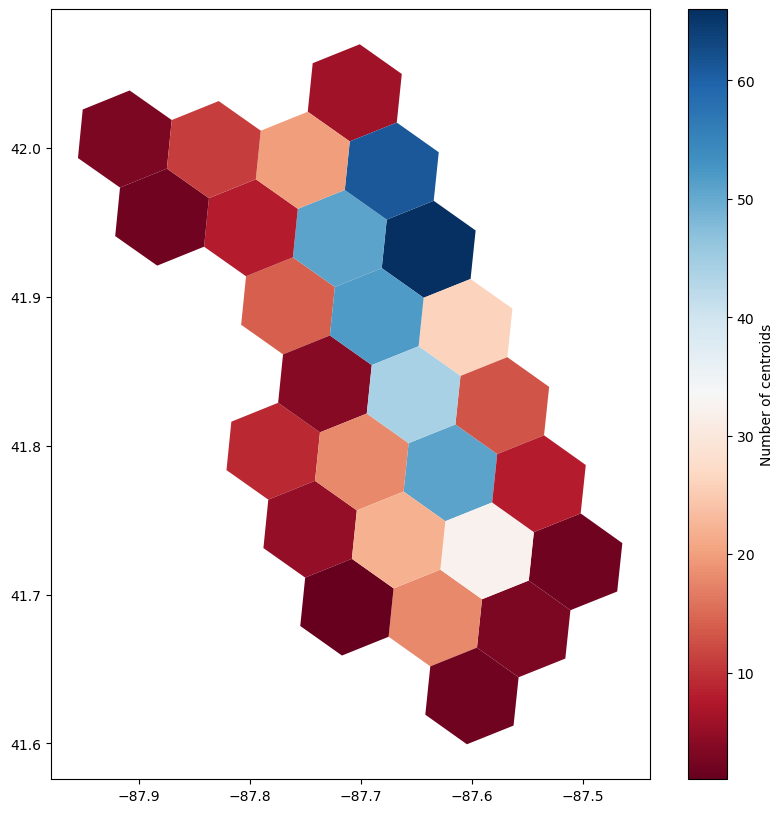

In [29]:
h3_centroids_geo_6.plot(legend=True, column='h3_6_count', figsize=(10, 10), cmap='RdBu', legend_kwds = {'label': "Number of centroids"})

#### H3 - Resolution 7 - Centroid Aggregation

<Axes: >

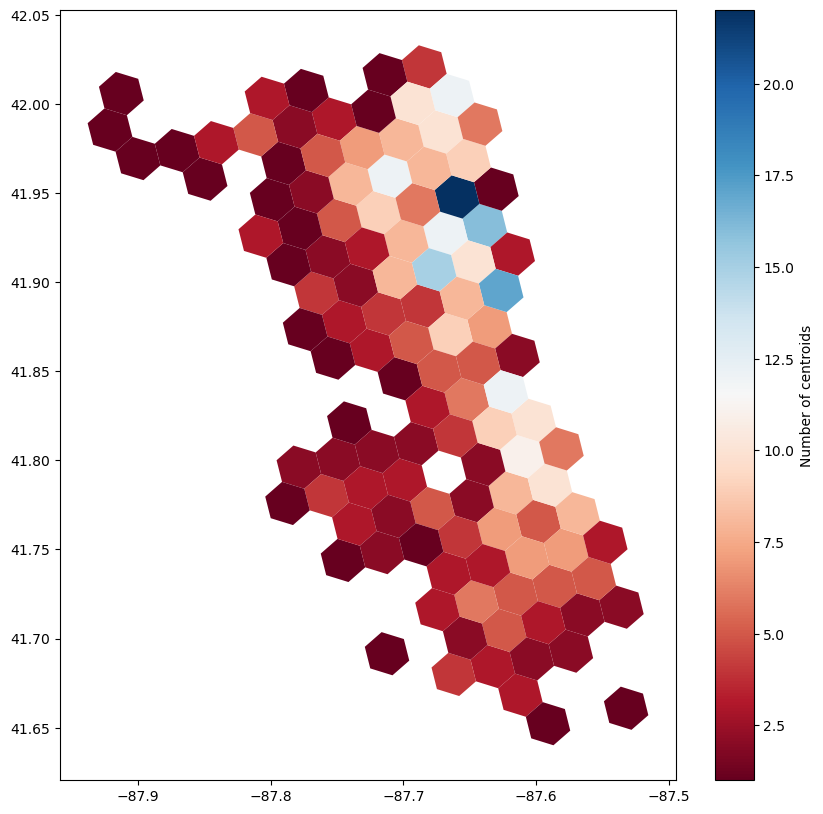

In [30]:
h3_centroids_geo_7.plot(legend=True, column='h3_7_count', figsize=(10, 10), cmap='RdBu', legend_kwds = {'label': "Number of centroids"})

#### H3 - Resolution 8 - Centroid Aggregation

<Axes: >

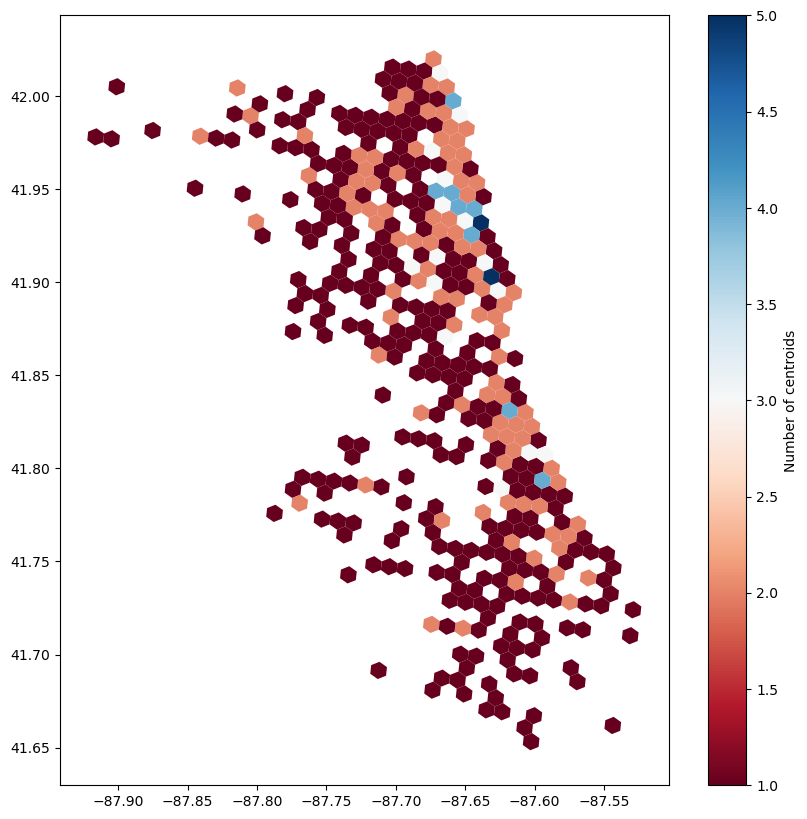

In [31]:
h3_centroids_geo_8.plot(legend=True, column='h3_8_count', figsize=(10, 10), cmap='RdBu', legend_kwds = {'label': "Number of centroids"})

The inner city of the resolution 6 grid contains up to 60 centroids, with the downside of having only a few hexagons in its entirety, which can make any spatial interpretations difficult.
On the other side, the grid of resolution 8 has many hexagons that only contain one single centroid and are not better than just taking the centroid data itself in that regard.
The hexagonal grid of resulution 7 seems balanced with many hexagons containing several centroids.

We add these h3 codes of all specified resolutions to the taxi dataset, both for pickup and dropoff.
As not every datapoint has a specific census tract, the more unspecific community area centroid h3 code is used in these cases.

In [32]:
taxi

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,trip_total,company,payment_type,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed
0,505af6c6eb3cc5b3098f9c565af55e7ef6397d94,175a58299af3a8c883453259b9a0cfc45ccbbbe1a07883...,2021-01-01 00:00:00,2021-01-01 00:00:00,NaN,NaN,8.0,8.0,165.0,0.30,5.00,Medallion Leasin,Cash,-1.33,0,6.35,-1.33,0,6.35
63,b6a1c6f16a7f52cdfed0476891b7c8d58440011c,931225a382fc38a75212f9d358439aec0d9b50fdaf32ad...,2021-01-01 00:00:00,2021-01-01 00:45:00,NaN,NaN,14.0,22.0,2361.0,9.05,28.00,Flash Cab,Prcard,-1.33,0,6.35,-1.33,0,6.35
37,a76c9cae097af5ff1dfef35b376a832f54d789ea,72920f6ebc5830d39039323cf78a316085444eb8f8b272...,2021-01-01 00:00:00,2021-01-01 00:30:00,NaN,NaN,8.0,68.0,1800.0,9.80,29.00,Taxi Affiliation Services,Cash,-1.33,0,6.35,-1.33,0,6.35
38,11b01b6ac8d706e3fe522ee17d1cb7bae4851c45,be435bc4d6744155b3272e9edded016bd4afb347774701...,2021-01-01 00:00:00,2021-01-01 00:30:00,NaN,NaN,56.0,75.0,1260.0,9.20,34.33,Medallion Leasin,Credit Card,-1.33,0,6.35,-1.33,0,6.35
39,cdb55aa436f49734bec7dbe95605ef698819992d,a7aaa6374b9f88b5fd31a1106378dffccb77e1261bc57a...,2021-01-01 00:00:00,2021-01-01 00:30:00,NaN,NaN,8.0,1.0,1555.0,8.80,26.00,Flash Cab,Cash,-1.33,0,6.35,-1.33,0,6.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3714039,74c03d3b2cc01c2fd99ae5f5ce57178dd14f69c6,f6138aa35e1fb074eb79fbe29f512b6153dca3593d8cd2...,2021-12-31 23:45:00,2021-12-31 23:45:00,NaN,NaN,32.0,32.0,0.0,0.00,3.25,"Taxicab Insurance Agency, LLC",Cash,3.80,0,10.83,3.80,0,10.83
3714041,7962fad0b43d436e33e28dac5ac3d382f8528648,00aeef49089b36ed668920fac1119a26fb25d1b48102a4...,2021-12-31 23:45:00,2021-12-31 23:45:00,NaN,NaN,32.0,32.0,480.0,0.00,7.25,Taxi Affiliation Services,Cash,3.80,0,10.83,3.80,0,10.83
3714042,82ed59db635e4e5b70f593ee11dc7ffd27671f26,51510e6801fd5dfa9232c990f9578c24febaf1cacdba40...,2021-12-31 23:45:00,2021-12-31 23:45:00,NaN,NaN,8.0,8.0,240.0,0.50,6.75,"Taxicab Insurance Agency, LLC",Cash,3.80,0,10.83,3.80,0,10.83
3714048,05f5290e1b7401d9ac27a3150db6c4135c9e33d1,929637055de3e69bd7558f9b7e2ac3832c4848215b3ab4...,2021-12-31 23:45:00,2021-12-31 23:45:00,NaN,NaN,7.0,7.0,60.0,0.00,55.00,"Taxicab Insurance Agency, LLC",Credit Card,3.80,0,10.83,3.80,0,10.83


In [33]:
# h3_6_pickup and dropoff can be duplicated if only this cell is executed more than once!

# First, the less specific community area is used to determine the respective h3 area code. 
# This code is then added as a column to the taxi dataset.
taxi = taxi.merge(right=taxi[taxi["pickup_community_area"].notna()].merge(right=geographic_data, how="left", left_on="pickup_community_area", right_on="Community_Area")[["trip_id", "h3_6"]], on="trip_id", how="left")
taxi.rename(columns={"h3_6" : "h3_6_pickup"}, inplace=True)
taxi = taxi.merge(right=taxi[taxi["dropoff_community_area"].notna()].merge(right=geographic_data, how="left", left_on="dropoff_community_area", right_on="Community_Area")[["trip_id", "h3_6"]], on="trip_id", how="left")
taxi.rename(columns={"h3_6" : "h3_6_dropoff"}, inplace=True)
# Then, the more specific census tract is used and the h3 area code is updated for rows containing census tract information.
taxi.update(other=taxi[taxi["pickup_census_tract"].notna()].merge(right=geographic_data, how="left", left_on="pickup_census_tract", right_on="Census_tract")[["trip_id", "h3_6"]].rename(columns={"h3_6" : "h3_6_pickup"}, inplace=True))
taxi.update(other=taxi[taxi["dropoff_census_tract"].notna()].merge(right=geographic_data, how="left", left_on="dropoff_census_tract", right_on="Census_tract")[["trip_id", "h3_6"]].rename(columns={"h3_6" : "h3_6_dropoff"}, inplace=True))

In [34]:
taxi

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,...,company,payment_type,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,h3_6_pickup,h3_6_dropoff
0,505af6c6eb3cc5b3098f9c565af55e7ef6397d94,175a58299af3a8c883453259b9a0cfc45ccbbbe1a07883...,2021-01-01 00:00:00,2021-01-01 00:00:00,NaN,NaN,8.0,8.0,165.0,0.30,...,Medallion Leasin,Cash,-1.33,0,6.35,-1.33,0,6.35,862664c1fffffff,862664c1fffffff
1,b6a1c6f16a7f52cdfed0476891b7c8d58440011c,931225a382fc38a75212f9d358439aec0d9b50fdaf32ad...,2021-01-01 00:00:00,2021-01-01 00:45:00,NaN,NaN,14.0,22.0,2361.0,9.05,...,Flash Cab,Prcard,-1.33,0,6.35,-1.33,0,6.35,862664ca7ffffff,862664ca7ffffff
2,a76c9cae097af5ff1dfef35b376a832f54d789ea,72920f6ebc5830d39039323cf78a316085444eb8f8b272...,2021-01-01 00:00:00,2021-01-01 00:30:00,NaN,NaN,8.0,68.0,1800.0,9.80,...,Taxi Affiliation Services,Cash,-1.33,0,6.35,-1.33,0,6.35,862664c1fffffff,862664cc7ffffff
3,11b01b6ac8d706e3fe522ee17d1cb7bae4851c45,be435bc4d6744155b3272e9edded016bd4afb347774701...,2021-01-01 00:00:00,2021-01-01 00:30:00,NaN,NaN,56.0,75.0,1260.0,9.20,...,Medallion Leasin,Credit Card,-1.33,0,6.35,-1.33,0,6.35,862664527ffffff,862664567ffffff
4,cdb55aa436f49734bec7dbe95605ef698819992d,a7aaa6374b9f88b5fd31a1106378dffccb77e1261bc57a...,2021-01-01 00:00:00,2021-01-01 00:30:00,NaN,NaN,8.0,1.0,1555.0,8.80,...,Flash Cab,Cash,-1.33,0,6.35,-1.33,0,6.35,862664c1fffffff,862664d8fffffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3714108,74c03d3b2cc01c2fd99ae5f5ce57178dd14f69c6,f6138aa35e1fb074eb79fbe29f512b6153dca3593d8cd2...,2021-12-31 23:45:00,2021-12-31 23:45:00,NaN,NaN,32.0,32.0,0.0,0.00,...,"Taxicab Insurance Agency, LLC",Cash,3.80,0,10.83,3.80,0,10.83,862664c1fffffff,862664c1fffffff
3714109,7962fad0b43d436e33e28dac5ac3d382f8528648,00aeef49089b36ed668920fac1119a26fb25d1b48102a4...,2021-12-31 23:45:00,2021-12-31 23:45:00,NaN,NaN,32.0,32.0,480.0,0.00,...,Taxi Affiliation Services,Cash,3.80,0,10.83,3.80,0,10.83,862664c1fffffff,862664c1fffffff
3714110,82ed59db635e4e5b70f593ee11dc7ffd27671f26,51510e6801fd5dfa9232c990f9578c24febaf1cacdba40...,2021-12-31 23:45:00,2021-12-31 23:45:00,NaN,NaN,8.0,8.0,240.0,0.50,...,"Taxicab Insurance Agency, LLC",Cash,3.80,0,10.83,3.80,0,10.83,862664c1fffffff,862664c1fffffff
3714111,05f5290e1b7401d9ac27a3150db6c4135c9e33d1,929637055de3e69bd7558f9b7e2ac3832c4848215b3ab4...,2021-12-31 23:45:00,2021-12-31 23:45:00,NaN,NaN,7.0,7.0,60.0,0.00,...,"Taxicab Insurance Agency, LLC",Credit Card,3.80,0,10.83,3.80,0,10.83,862664c17ffffff,862664c17ffffff


In [35]:
# This is repeated for resolutions 7...
taxi = taxi.merge(right=taxi[taxi["pickup_community_area"].notna()].merge(right=geographic_data[["Community_Area", "h3_7"]], how="left", left_on="pickup_community_area", right_on="Community_Area")[["trip_id", "h3_7"]], on="trip_id", how="left")
taxi.rename(columns={"h3_7" : "h3_7_pickup"}, inplace=True)
taxi = taxi.merge(right=taxi[taxi["dropoff_community_area"].notna()].merge(right=geographic_data[["Community_Area", "h3_7"]], how="left", left_on="dropoff_community_area", right_on="Community_Area")[["trip_id", "h3_7"]], on="trip_id", how="left")
taxi.rename(columns={"h3_7" : "h3_7_dropoff"}, inplace=True)
taxi.update(other=taxi[taxi["pickup_census_tract"].notna()].merge(right=geographic_data[["Census_tract", "h3_7"]], how="left", left_on="pickup_census_tract", right_on="Census_tract")[["trip_id", "h3_7"]].rename(columns={"h3_7" : "h3_7_pickup"}, inplace=True))
taxi.update(other=taxi[taxi["dropoff_census_tract"].notna()].merge(right=geographic_data[["Census_tract", "h3_7"]], how="left", left_on="dropoff_census_tract", right_on="Census_tract")[["trip_id", "h3_7"]].rename(columns={"h3_7" : "h3_7_dropoff"}, inplace=True))

In [36]:
#... and 8
taxi = taxi.merge(right=taxi[taxi["pickup_community_area"].notna()].merge(right=geographic_data[["Community_Area", "h3_8"]], how="left", left_on="pickup_community_area", right_on="Community_Area")[["trip_id", "h3_8"]], on="trip_id", how="left")
taxi.rename(columns={"h3_8" : "h3_8_pickup"}, inplace=True)
taxi = taxi.merge(right=taxi[taxi["dropoff_community_area"].notna()].merge(right=geographic_data[["Community_Area", "h3_8"]], how="left", left_on="dropoff_community_area", right_on="Community_Area")[["trip_id", "h3_8"]], on="trip_id", how="left")
taxi.rename(columns={"h3_8" : "h3_8_dropoff"}, inplace=True)
taxi.update(other=taxi[taxi["pickup_census_tract"].notna()].merge(right=geographic_data[["Census_tract", "h3_8"]], how="left", left_on="pickup_census_tract", right_on="Census_tract")[["trip_id", "h3_8"]].rename(columns={"h3_8" : "h3_8_pickup"}, inplace=True))
taxi.update(other=taxi[taxi["dropoff_census_tract"].notna()].merge(right=geographic_data[["Census_tract", "h3_8"]], how="left", left_on="dropoff_census_tract", right_on="Census_tract")[["trip_id", "h3_8"]].rename(columns={"h3_8" : "h3_8_dropoff"}, inplace=True))

In [37]:
taxi.head(10)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,...,start_windspeed,end_temp,end_precip,end_windspeed,h3_6_pickup,h3_6_dropoff,h3_7_pickup,h3_7_dropoff,h3_8_pickup,h3_8_dropoff
0,505af6c6eb3cc5b3098f9c565af55e7ef6397d94,175a58299af3a8c883453259b9a0cfc45ccbbbe1a07883...,2021-01-01,2021-01-01 00:00:00,NaN,NaN,8.0,8.0,165.0,0.30,...,6.35,-1.33,0,6.35,862664c1fffffff,862664c1fffffff,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff
1,b6a1c6f16a7f52cdfed0476891b7c8d58440011c,931225a382fc38a75212f9d358439aec0d9b50fdaf32ad...,2021-01-01,2021-01-01 00:45:00,NaN,NaN,14.0,22.0,2361.0,9.05,...,6.35,-1.33,0,6.35,862664ca7ffffff,862664ca7ffffff,872664d99ffffff,872664ca1ffffff,882664d993fffff,882664ca11fffff
2,a76c9cae097af5ff1dfef35b376a832f54d789ea,72920f6ebc5830d39039323cf78a316085444eb8f8b272...,2021-01-01,2021-01-01 00:30:00,NaN,NaN,8.0,68.0,1800.0,9.80,...,6.35,-1.33,0,6.35,862664c1fffffff,862664cc7ffffff,872664c1effffff,872664cc2ffffff,882664c1edfffff,882664cc2bfffff
3,11b01b6ac8d706e3fe522ee17d1cb7bae4851c45,be435bc4d6744155b3272e9edded016bd4afb347774701...,2021-01-01,2021-01-01 00:30:00,NaN,NaN,56.0,75.0,1260.0,9.20,...,6.35,-1.33,0,6.35,862664527ffffff,862664567ffffff,872664520ffffff,872664562ffffff,882664520bfffff,882664562dfffff
4,cdb55aa436f49734bec7dbe95605ef698819992d,a7aaa6374b9f88b5fd31a1106378dffccb77e1261bc57a...,2021-01-01,2021-01-01 00:30:00,NaN,NaN,8.0,1.0,1555.0,8.80,...,6.35,-1.33,0,6.35,862664c1fffffff,862664d8fffffff,872664c1effffff,872664d8cffffff,882664c1edfffff,882664d8cdfffff
5,e28f968f76c2a06f69e60b907f63718074b99ff4,1f4ebbfdcaa03dba403f6f41c2434baa8cd6583b0fde73...,2021-01-01,2021-01-01 00:15:00,NaN,NaN,70.0,42.0,1620.0,7.10,...,6.35,-1.33,0,6.35,86266452fffffff,862664cc7ffffff,87266452dffffff,872664cc5ffffff,88266452dbfffff,882664cc57fffff
6,855259d1bc129f6370f038aa910067972eeae037,0aba795cd29b34ff868043bc923a341f37c4f6d7afabe4...,2021-01-01,2021-01-01 00:15:00,NaN,NaN,28.0,22.0,900.0,0.30,...,6.35,-1.33,0,6.35,862664cafffffff,862664ca7ffffff,872664ca9ffffff,872664ca1ffffff,882664ca91fffff,882664ca11fffff
7,820a917a49280f0ee5ba61802ae5d13c55bf51ed,7476a493f34aa1075570e89104cdaf3aaf5c0fd4679382...,2021-01-01,2021-01-01 00:15:00,NaN,NaN,33.0,NaN,960.0,10.60,...,6.35,-1.33,0,6.35,862664c1fffffff,NaN,872664c1bffffff,NaN,882664c1b5fffff,NaN
8,88194fab0a0a28df1b87e9f358143197d004d4d9,e11ecc8e74a2d3cbd2e9f58151ed09c81587cb491c50f6...,2021-01-01,2021-01-01 00:15:00,NaN,NaN,6.0,4.0,1140.0,4.30,...,6.35,-1.33,0,6.35,862664c17ffffff,862664d8fffffff,872664c16ffffff,872664d8affffff,882664c163fffff,882664d8bdfffff
9,02fc5d8c3e8525a49b7514bd6c2b3301c2d6aa79,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2021-01-01,2021-01-01 00:15:00,NaN,NaN,NaN,4.0,1021.0,3.17,...,6.35,-1.33,0,6.35,NaN,862664d8fffffff,NaN,872664d8affffff,NaN,882664d8bdfffff


In [38]:
#export this first processed geographical version for further use
taxi.to_csv(f"{file_path}taxi_processed.csv", index=False)

## Geographical Aggregation

We continue by aggregating the data by the different geographical dimensions available (census tract, community area and h3 hexagons) to get various information, including the mean trip distance, mean trip temperature and the amount of trips started in this area. 

In [39]:
def create_geographical_aggregation(geo_column_name_taxi_pickup, geo_column_name_taxi_dropoff):
    taxi_dropped = taxi.drop(["taxi_id", "trip_start_timestamp", "trip_end_timestamp", "company", "payment_type"], axis=1)
    # Group by pickup geographical location and take mean values of relevant information and count the number of trips
    taxi_by_geo = taxi_dropped.groupby(geo_column_name_taxi_pickup).agg({"trip_id":"count","trip_seconds":"mean","trip_miles":"mean","trip_total":"mean","start_temp":"mean","start_precip":"mean","start_windspeed":"mean","end_temp":"mean","end_precip":"mean","end_windspeed":"mean"}).reset_index()
    taxi_by_geo.rename(columns={"trip_seconds":"mean_trip_seconds","trip_id":"trip_amount_pickup","trip_miles":"mean_trip_miles","trip_total":"mean_trip_total"}, inplace=True)
    # Also group by dropoff geographical location, but only for trip amounts
    taxi_by_geo_dropoff = taxi_dropped.groupby(geo_column_name_taxi_dropoff).agg({"trip_id":"count"})
    taxi_by_geo_dropoff.rename(columns={"trip_id" : "trip_amount_dropoff"}, inplace=True)
    # Merge the dropoff trip amount into the taxi_by_geo dataframe
    taxi_by_geo = taxi_by_geo.merge(right=taxi_by_geo_dropoff["trip_amount_dropoff"], how="outer", left_on=geo_column_name_taxi_pickup, right_on=geo_column_name_taxi_dropoff)
    # Fill NaN values with 0, because it not appearing in the dataframe means that no trips started/ended there
    taxi_by_geo["trip_amount_pickup"].fillna(0, inplace=True)
    taxi_by_geo["trip_amount_dropoff"].fillna(0, inplace=True)
    taxi_by_geo["trip_amount_balance"] = taxi_by_geo["trip_amount_dropoff"] - taxi_by_geo["trip_amount_pickup"]
    return taxi_by_geo.dropna()

We have geographic areas for the h3 columns, but not yet for the census tract and community areas. We need to define another function to merge the geometry columns added previously to the new dataframes.

In [40]:
def merge_geometry(taxi_by_geo, agg_column_name_taxi, agg_column_name_geo):
    return taxi_by_geo.merge(right=geographic_data.dropna(subset=[agg_column_name_geo])[[agg_column_name_geo, "geometry"]], how="left", left_on=agg_column_name_taxi, right_on=agg_column_name_geo).drop([agg_column_name_geo], axis=1).dropna()

In [41]:
taxi_by_census_tract = create_geographical_aggregation("pickup_census_tract", "dropoff_census_tract")
taxi_by_census_tract = merge_geometry(taxi_by_census_tract, "pickup_census_tract", "Census_tract")
taxi_by_census_tract.rename(columns={"pickup_census_tract" : "census_tract"}, inplace=True)
taxi_by_census_tract.info()
taxi_by_census_tract

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 0 to 482
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   census_tract         474 non-null    float64
 1   trip_amount_pickup   474 non-null    float64
 2   mean_trip_seconds    474 non-null    float64
 3   mean_trip_miles      474 non-null    float64
 4   mean_trip_total      474 non-null    float64
 5   start_temp           474 non-null    float64
 6   start_precip         474 non-null    float64
 7   start_windspeed      474 non-null    float64
 8   end_temp             474 non-null    float64
 9   end_precip           474 non-null    float64
 10  end_windspeed        474 non-null    float64
 11  trip_amount_dropoff  474 non-null    float64
 12  trip_amount_balance  474 non-null    float64
 13  geometry             474 non-null    object 
dtypes: float64(13), object(1)
memory usage: 55.5+ KB


,census_tract,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance,geometry
0,1.703101e+10,8.0,1156.625000,6.808750,21.138750,9.462500,0.000000,6.060000,9.751250,0.000000,5.763750,7.0,-1.0,MULTIPOLYGON (((-87.66368000002299 42.01939800...
1,1.703101e+10,12.0,821.250000,5.105000,15.916667,16.375833,0.000000,6.034167,16.500833,0.000000,5.953333,9.0,-3.0,MULTIPOLYGON (((-87.6800950000417 42.012537999...
2,1.703101e+10,13.0,987.000000,5.202308,17.540000,16.421538,0.000000,6.333846,16.420769,0.000000,6.309231,23.0,10.0,MULTIPOLYGON (((-87.67335799998422 42.01937400...
3,1.703101e+10,16.0,1298.937500,5.431250,22.761875,12.832500,0.000000,6.209375,12.793750,0.000000,6.176875,30.0,14.0,MULTIPOLYGON (((-87.66505999995483 42.01280100...
4,1.703101e+10,5.0,873.400000,3.542000,14.400000,6.358000,0.000000,8.954000,6.174000,0.200000,8.956000,38.0,33.0,MULTIPOLYGON (((-87.65080299995667 41.99848500...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,1.703184e+10,32.0,465.156250,1.837813,11.225625,11.367500,0.093750,8.517500,11.375625,0.093750,8.480000,55.0,23.0,MULTIPOLYGON (((-87.61128600000754 41.80216899...
479,1.703184e+10,8.0,282.875000,0.810000,5.093750,9.451250,0.000000,8.640000,9.451250,0.000000,8.640000,21.0,13.0,MULTIPOLYGON (((-87.69666899996376 41.94854100...
480,1.703184e+10,48.0,1262.625000,6.800000,22.141250,14.693958,0.020833,6.787500,14.570417,0.020833,6.873958,63.0,15.0,MULTIPOLYGON (((-87.55868599996295 41.77379199...
481,1.703198e+10,204650.0,1870.801217,12.351382,49.462406,16.331312,0.075876,6.919279,16.250797,0.076580,6.952971,87990.0,-116660.0,MULTIPOLYGON (((-87.92062799997296 42.00453199...


In [42]:
taxi_by_community_area = create_geographical_aggregation("pickup_community_area", "dropoff_community_area")
taxi_by_community_area = merge_geometry(taxi_by_community_area, "pickup_community_area", "Community_Area")
taxi_by_community_area.rename(columns={"pickup_community_area" : "community_area"}, inplace=True)
taxi_by_community_area.info()
taxi_by_community_area.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 76
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   community_area       77 non-null     float64
 1   trip_amount_pickup   77 non-null     int64  
 2   mean_trip_seconds    77 non-null     float64
 3   mean_trip_miles      77 non-null     float64
 4   mean_trip_total      77 non-null     float64
 5   start_temp           77 non-null     float64
 6   start_precip         77 non-null     float64
 7   start_windspeed      77 non-null     float64
 8   end_temp             77 non-null     float64
 9   end_precip           77 non-null     float64
 10  end_windspeed        77 non-null     float64
 11  trip_amount_dropoff  77 non-null     int64  
 12  trip_amount_balance  77 non-null     int64  
 13  geometry             77 non-null     object 
dtypes: float64(10), int64(3), object(1)
memory usage: 9.0+ KB


,community_area,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance,geometry
0,1.0,31736,1285.285701,5.477606,20.380681,12.076254,0.055205,7.007664,12.094891,0.056088,7.021015,38533,6797,MULTIPOLYGON (((-87.65455590025104 41.99816614...
1,2.0,40026,1351.675861,5.163012,19.674839,12.178111,0.056114,7.054096,12.197042,0.055339,7.071303,41056,1030,MULTIPOLYGON (((-87.6846530946559 42.019484772...
2,3.0,71947,946.209668,3.952473,16.707363,12.607201,0.059377,7.056347,12.614591,0.059683,7.069810,85725,13778,MULTIPOLYGON (((-87.64102430213292 41.95480280...
3,4.0,21524,1059.099052,3.867665,16.833486,12.201093,0.057192,7.048262,12.203688,0.056634,7.061142,30176,8652,MULTIPOLYGON (((-87.6744075678037 41.976103404...
4,5.0,12951,1042.085090,3.565721,17.415725,12.672353,0.057447,7.059346,12.682269,0.056830,7.069954,27788,14837,MULTIPOLYGON (((-87.67336415409336 41.93234274...


In [43]:
taxi_by_h3_6 = create_geographical_aggregation("h3_6_pickup", "h3_6_dropoff")
taxi_by_h3_6.info()
taxi_by_h3_6.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   h3_6_pickup          25 non-null     object 
 1   trip_amount_pickup   25 non-null     int64  
 2   mean_trip_seconds    25 non-null     float64
 3   mean_trip_miles      25 non-null     float64
 4   mean_trip_total      25 non-null     float64
 5   start_temp           25 non-null     float64
 6   start_precip         25 non-null     float64
 7   start_windspeed      25 non-null     float64
 8   end_temp             25 non-null     float64
 9   end_precip           25 non-null     float64
 10  end_windspeed        25 non-null     float64
 11  trip_amount_dropoff  25 non-null     int64  
 12  trip_amount_balance  25 non-null     int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 2.7+ KB


,h3_6_pickup,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance
0,862664197ffffff,10934,1401.645327,9.073257,28.867198,11.809961,0.055515,7.069226,11.849291,0.053594,7.089692,8153,-2781
1,8626641b7ffffff,3054,1762.617551,8.351588,29.271853,12.553893,0.063851,7.071847,12.487809,0.065815,7.105956,1634,-1420
2,862664527ffffff,120683,1565.060605,9.470445,39.959034,14.621903,0.067491,6.960829,14.562111,0.067151,6.981360,48016,-72667
3,86266452fffffff,5721,1860.701276,6.848481,26.378724,12.836296,0.055060,7.020234,12.901026,0.056808,7.042984,6171,450
4,862664567ffffff,33208,1354.609371,9.264621,29.009060,12.466658,0.052186,6.962850,12.514847,0.051674,6.978872,32906,-302


In [44]:
taxi_by_h3_7 = create_geographical_aggregation("h3_7_pickup", "h3_7_dropoff")
taxi_by_h3_7.info()
taxi_by_h3_7.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 0 to 71
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   h3_7_pickup          72 non-null     object 
 1   trip_amount_pickup   72 non-null     int64  
 2   mean_trip_seconds    72 non-null     float64
 3   mean_trip_miles      72 non-null     float64
 4   mean_trip_total      72 non-null     float64
 5   start_temp           72 non-null     float64
 6   start_precip         72 non-null     float64
 7   start_windspeed      72 non-null     float64
 8   end_temp             72 non-null     float64
 9   end_precip           72 non-null     float64
 10  end_windspeed        72 non-null     float64
 11  trip_amount_dropoff  72 non-null     int64  
 12  trip_amount_balance  72 non-null     int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 7.9+ KB


,h3_7_pickup,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance
0,872664191ffffff,2631,1419.560243,10.077092,31.242444,12.195279,0.057013,7.194645,12.233345,0.054732,7.196769,1346,-1285
1,872664196ffffff,8303,1395.968566,8.755168,28.114545,11.687863,0.055040,7.029485,11.727595,0.053234,7.055762,6807,-1496
2,8726641b2ffffff,3054,1762.617551,8.351588,29.271853,12.553893,0.063851,7.071847,12.487809,0.065815,7.105956,1634,-1420
3,872664520ffffff,119032,1565.700560,9.513155,40.130559,14.650490,0.067662,6.960942,14.589098,0.067301,6.981103,45573,-73459
4,872664521ffffff,1651,1518.921866,6.391199,27.592586,12.560915,0.055118,6.952744,12.616420,0.056329,6.999897,2443,792


In [45]:
taxi_by_h3_8 = create_geographical_aggregation("h3_8_pickup", "h3_8_dropoff")
taxi_by_h3_8.info()
taxi_by_h3_8.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 76
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   h3_8_pickup          77 non-null     object 
 1   trip_amount_pickup   77 non-null     int64  
 2   mean_trip_seconds    77 non-null     float64
 3   mean_trip_miles      77 non-null     float64
 4   mean_trip_total      77 non-null     float64
 5   start_temp           77 non-null     float64
 6   start_precip         77 non-null     float64
 7   start_windspeed      77 non-null     float64
 8   end_temp             77 non-null     float64
 9   end_precip           77 non-null     float64
 10  end_windspeed        77 non-null     float64
 11  trip_amount_dropoff  77 non-null     int64  
 12  trip_amount_balance  77 non-null     int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 8.4+ KB


,h3_8_pickup,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance
0,8826641915fffff,2631,1419.560243,10.077092,31.242444,12.195279,0.057013,7.194645,12.233345,0.054732,7.196769,1346,-1285
1,8826641961fffff,8303,1395.968566,8.755168,28.114545,11.687863,0.055040,7.029485,11.727595,0.053234,7.055762,6807,-1496
2,8826641b23fffff,3054,1762.617551,8.351588,29.271853,12.553893,0.063851,7.071847,12.487809,0.065815,7.105956,1634,-1420
3,882664520bfffff,119032,1565.700560,9.513155,40.130559,14.650490,0.067662,6.960942,14.589098,0.067301,6.981103,45573,-73459
4,8826645215fffff,1651,1518.921866,6.391199,27.592586,12.560915,0.055118,6.952744,12.616420,0.056329,6.999897,2443,792


In [46]:
taxi_by_census_tract.to_csv(f"{file_path}taxi_by_census_tract.csv", index=False)
taxi_by_community_area.to_csv(f"{file_path}taxi_by_community_area.csv", index=False)
taxi_by_h3_6.to_csv(f"{file_path}taxi_by_h3_6.csv", index=False)
taxi_by_h3_7.to_csv(f"{file_path}taxi_by_h3_7.csv", index=False)
taxi_by_h3_8.to_csv(f"{file_path}taxi_by_h3_8.csv", index=False)

## Different hourly aggregations

In the next part we will further discretize our trips regarding the temporal dimension, with different hourly aggregations. We will start with splitting the data into hourly data

In [47]:
taxi_reorg = taxi.drop(["taxi_id", "trip_end_timestamp", "pickup_census_tract", "dropoff_census_tract", "pickup_community_area", "dropoff_community_area", "company", "payment_type"], axis=1)
taxi_by_hour = taxi_reorg.groupby(pd.Grouper(key='trip_start_timestamp',freq='1H')).agg({"trip_id":"count","trip_seconds":"mean","trip_miles":"mean","trip_total":"mean","start_temp":"mean","start_precip":"mean","start_windspeed":"mean","end_temp":"mean","end_precip":"mean","end_windspeed":"mean"})
taxi_by_hour.rename(columns={"trip_seconds":"mean_trip_seconds","trip_id":"trip_amount","trip_miles":"mean_trip_miles","trip_total":"mean_trip_total"}, inplace=True)
taxi_by_hour.info()
taxi_by_hour.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2021-01-01 00:00:00 to 2021-12-31 23:00:00
Freq: H
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trip_amount        8760 non-null   int64  
 1   mean_trip_seconds  8759 non-null   float64
 2   mean_trip_miles    8759 non-null   float64
 3   mean_trip_total    8759 non-null   float64
 4   start_temp         8759 non-null   float64
 5   start_precip       8759 non-null   float64
 6   start_windspeed    8759 non-null   float64
 7   end_temp           8759 non-null   float64
 8   end_precip         8759 non-null   float64
 9   end_windspeed      8759 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 752.8 KB


,trip_amount,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed
trip_start_timestamp,,,,,,,,,,
2021-01-01 00:00:00,82,872.573171,4.837927,19.556829,-1.33,0.0,6.35,-1.319024,0.0,6.519024
2021-01-01 01:00:00,51,934.078431,5.023529,17.980392,-1.28,0.0,7.12,-1.285882,0.0,7.190588
2021-01-01 02:00:00,53,763.509434,4.466415,16.875283,-1.31,0.0,7.48,-1.281698,0.0,7.446038
2021-01-01 03:00:00,38,773.105263,4.000526,17.217368,-1.16,0.0,7.30,-1.136316,0.0,7.303947
2021-01-01 04:00:00,29,903.655172,3.885517,19.018621,-0.98,0.0,7.33,-0.906207,0.0,7.615172


There seems to be one hour without any data, we will check this and fill it with the data of the row beforehand

In [48]:
taxi_by_hour[taxi_by_hour["trip_amount"] == 0]

,trip_amount,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed
trip_start_timestamp,,,,,,,,,,
2021-03-14 02:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
taxi_by_hour[taxi_by_hour["trip_amount"] == 0] = taxi_by_hour.ffill()
taxi_by_hour.info()
taxi_by_hour.loc["2021-03-14 02:00:00"]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2021-01-01 00:00:00 to 2021-12-31 23:00:00
Freq: H
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trip_amount        8760 non-null   int64  
 1   mean_trip_seconds  8760 non-null   float64
 2   mean_trip_miles    8760 non-null   float64
 3   mean_trip_total    8760 non-null   float64
 4   start_temp         8760 non-null   float64
 5   start_precip       8760 non-null   float64
 6   start_windspeed    8760 non-null   float64
 7   end_temp           8760 non-null   float64
 8   end_precip         8760 non-null   float64
 9   end_windspeed      8760 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 1010.9 KB


trip_amount            0.000000
mean_trip_seconds    948.478992
mean_trip_miles        3.599916
mean_trip_total       17.107899
start_temp             3.750000
start_precip           0.000000
start_windspeed        9.200000
end_temp               3.612185
end_precip             0.000000
end_windspeed          9.322689
Name: 2021-03-14 02:00:00, dtype: float64

In [50]:
#export this hourly aggregated version for further use
taxi_by_hour.to_csv(f"{file_path}taxi_hourly_processed.csv")
del taxi_by_hour

Next we will split the trips in 4 hourly splits

In [51]:
taxi_by_4hour = taxi.groupby(pd.Grouper(key='trip_start_timestamp',freq='4H')).agg({"trip_id":"count","trip_seconds":"mean","trip_miles":"mean","trip_total":"mean","start_temp":"mean","start_precip":"mean","start_windspeed":"mean","end_temp":"mean","end_precip":"mean","end_windspeed":"mean"})
taxi_by_4hour.rename(columns={"trip_seconds":"mean_trip_seconds","trip_id":"trip_amount","trip_miles":"mean_trip_miles","trip_total":"mean_trip_total"}, inplace=True)
taxi_by_4hour.info()
taxi_by_4hour.to_csv(f"{file_path}taxi_4_hourly_processed.csv")
taxi_by_4hour.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2021-01-01 00:00:00 to 2021-12-31 20:00:00
Freq: 4H
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trip_amount        2190 non-null   int64  
 1   mean_trip_seconds  2190 non-null   float64
 2   mean_trip_miles    2190 non-null   float64
 3   mean_trip_total    2190 non-null   float64
 4   start_temp         2190 non-null   float64
 5   start_precip       2190 non-null   float64
 6   start_windspeed    2190 non-null   float64
 7   end_temp           2190 non-null   float64
 8   end_precip         2190 non-null   float64
 9   end_windspeed      2190 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 188.2 KB


,trip_amount,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed
trip_start_timestamp,,,,,,,,,,
2021-01-01 00:00:00,224,843.897321,4.650223,18.166563,-1.285045,0.000000,6.953839,-1.271652,0.000000,7.024420
2021-01-01 04:00:00,156,880.012821,5.890128,20.501346,-0.423013,0.000000,9.206667,-0.350577,0.000000,9.417756
2021-01-01 08:00:00,434,970.311060,5.709309,21.174263,0.196382,0.320276,10.717788,0.265092,0.398618,10.765023
2021-01-01 12:00:00,761,1031.434954,5.424717,20.822365,1.218962,1.000000,11.249829,1.262208,0.923784,11.304350
2021-01-01 16:00:00,660,1138.340909,6.204561,23.832561,1.536242,0.231818,11.083439,1.521591,0.303030,10.849333


Concluding we will split the data into

In [52]:
taxi_by_day = taxi.groupby(pd.Grouper(key='trip_start_timestamp',freq='d')).agg({"trip_id":"count","trip_seconds":"mean","trip_miles":"mean","trip_total":"mean","start_temp":"mean","start_precip":"mean","start_windspeed":"mean","end_temp":"mean","end_precip":"mean","end_windspeed":"mean"})
taxi_by_day.rename(columns={"trip_seconds":"mean_trip_seconds","trip_id":"trip_amount","trip_miles":"mean_trip_miles","trip_total":"mean_trip_total"}, inplace=True)
taxi_by_day.info()
taxi_by_day.to_csv(f"{file_path}taxi_daily_processed.csv")
taxi_by_day.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-01-01 to 2021-12-31
Freq: D
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trip_amount        365 non-null    int64  
 1   mean_trip_seconds  365 non-null    float64
 2   mean_trip_miles    365 non-null    float64
 3   mean_trip_total    365 non-null    float64
 4   start_temp         365 non-null    float64
 5   start_precip       365 non-null    float64
 6   start_windspeed    365 non-null    float64
 7   end_temp           365 non-null    float64
 8   end_precip         365 non-null    float64
 9   end_windspeed      365 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 31.4 KB


,trip_amount,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed
trip_start_timestamp,,,,,,,,,,
2021-01-01,2717,1054.298859,6.099989,23.005425,0.890291,0.444240,10.338907,0.925701,0.435407,10.346187
2021-01-02,4118,1073.296989,5.963327,23.184310,1.796574,0.000000,3.918924,1.772812,0.000000,3.922300
2021-01-03,3639,1072.172025,7.379272,27.713858,0.186678,0.022259,4.620239,0.078673,0.026381,4.660596
2021-01-04,5668,991.735533,5.264190,20.399884,-1.312578,0.000000,5.855162,-1.260842,0.000000,5.887754
2021-01-05,5153,983.744033,4.752045,18.901547,0.413514,0.000000,3.954648,0.414912,0.000000,3.853736


## Geotemporal Aggregation

After aggregating the data geographically and temporally, we also aggregate it geotemporally, including both dimensions at once. This gives us new insights how each geographical location behaves at which time

In [53]:
def create_geo_temporal_aggregation(geo_column_name_taxi_pickup, geo_column_name_taxi_dropoff, freq):
    taxi_dropped = taxi.drop(["taxi_id", "trip_end_timestamp", "company", "payment_type"], axis=1)
    # Group by pickup geographical location as well as start time
    # and take mean values of relevant information and count the number of trips
    taxi_by_geotemp = taxi_dropped.groupby([pd.Grouper(key='trip_start_timestamp',freq=freq), pd.Grouper(geo_column_name_taxi_pickup)]).agg({"trip_id":"count","trip_seconds":"mean","trip_miles":"mean","trip_total":"mean","start_temp":"mean","start_precip":"mean","start_windspeed":"mean","end_temp":"mean","end_precip":"mean","end_windspeed":"mean"})
    taxi_by_geotemp.rename(columns={"trip_seconds":"mean_trip_seconds","trip_id":"trip_amount_pickup","trip_miles":"mean_trip_miles","trip_total":"mean_trip_total"}, inplace=True)
    # Also group by dropoff geographical location, but only for trip amounts
    taxi_by_geotemp_dropoff = taxi_dropped.groupby([pd.Grouper(key='trip_start_timestamp',freq=freq), pd.Grouper(geo_column_name_taxi_dropoff)]).agg({"trip_id":"count"})
    taxi_by_geotemp_dropoff.rename(columns={"trip_id" : "trip_amount_dropoff"}, inplace=True)
    # Merge the dropoff trip amount into the taxi_by_geotemp dataframe
    taxi_by_geotemp = taxi_by_geotemp.reset_index().merge(right=taxi_by_geotemp_dropoff, how="outer", left_on=[geo_column_name_taxi_pickup, "trip_start_timestamp"], right_on=[geo_column_name_taxi_dropoff, "trip_start_timestamp"])
    # Drop row when either timestamp or geographical location is empty, as that data is not useful for geotemporal analysis
    taxi_by_geotemp.dropna(subset=[geo_column_name_taxi_pickup, "trip_start_timestamp"], inplace=True)
    # Fill NaN values with 0, because it not appearing in the dataframe means that no trips started/ended there
    taxi_by_geotemp["trip_amount_pickup"].fillna(0, inplace=True)
    taxi_by_geotemp["trip_amount_dropoff"].fillna(0, inplace=True)
    taxi_by_geotemp["trip_amount_balance"] = taxi_by_geotemp["trip_amount_dropoff"] - taxi_by_geotemp["trip_amount_pickup"]
    return taxi_by_geotemp

In [54]:
taxi_by_h3_6_1H = create_geo_temporal_aggregation("h3_6_pickup", "h3_6_dropoff", "1H")
taxi_by_h3_7_1H = create_geo_temporal_aggregation("h3_7_pickup", "h3_7_dropoff", "1H")
taxi_by_h3_8_1H = create_geo_temporal_aggregation("h3_8_pickup", "h3_8_dropoff", "1H")
taxi_by_census_tract_1H = create_geo_temporal_aggregation("pickup_census_tract", "dropoff_census_tract", "1H")
taxi_by_census_tract_1H = merge_geometry(taxi_by_census_tract_1H, "pickup_census_tract", "Census_tract")
taxi_by_census_tract_1H.rename(columns={"pickup_census_tract" : "census_tract"}, inplace=True)
taxi_by_community_area_1H = create_geo_temporal_aggregation("pickup_community_area", "dropoff_community_area", "1H")
taxi_by_community_area_1H = merge_geometry(taxi_by_community_area_1H, "pickup_community_area", "Community_Area")
taxi_by_community_area_1H.rename(columns={"pickup_community_area" : "community_area"}, inplace=True)
taxi_by_h3_6_1H.info()
taxi_by_h3_6_1H.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163429 entries, 0 to 163428
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   trip_start_timestamp  163429 non-null  datetime64[ns]
 1   h3_6_pickup           163429 non-null  object        
 2   trip_amount_pickup    163429 non-null  float64       
 3   mean_trip_seconds     163429 non-null  float64       
 4   mean_trip_miles       163429 non-null  float64       
 5   mean_trip_total       163429 non-null  float64       
 6   start_temp            163429 non-null  float64       
 7   start_precip          163429 non-null  float64       
 8   start_windspeed       163429 non-null  float64       
 9   end_temp              163429 non-null  float64       
 10  end_precip            163429 non-null  float64       
 11  end_windspeed         163429 non-null  float64       
 12  trip_amount_dropoff   163429 non-null  float64       
 13 

,trip_start_timestamp,h3_6_pickup,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance
0,2021-01-01,862664527ffffff,4.0,1215.0,8.675000,43.895000,-1.33,0.0,6.35,-1.305000,0.0,6.735000,1.0,-3.0
1,2021-01-01,86266452fffffff,1.0,1620.0,7.100000,22.250000,-1.33,0.0,6.35,-1.330000,0.0,6.350000,1.0,0.0
2,2021-01-01,862664567ffffff,1.0,781.0,5.010000,15.000000,-1.33,0.0,6.35,-1.330000,0.0,6.350000,1.0,0.0
3,2021-01-01,862664c17ffffff,5.0,966.6,3.304000,16.100000,-1.33,0.0,6.35,-1.330000,0.0,6.350000,6.0,1.0
4,2021-01-01,862664c1fffffff,24.0,601.0,3.458333,14.174167,-1.33,0.0,6.35,-1.325833,0.0,6.414167,15.0,-9.0


In [55]:
taxi_by_h3_6_4H = create_geo_temporal_aggregation("h3_6_pickup", "h3_6_dropoff", "4H")
taxi_by_h3_7_4H = create_geo_temporal_aggregation("h3_7_pickup", "h3_7_dropoff", "4H")
taxi_by_h3_8_4H = create_geo_temporal_aggregation("h3_8_pickup", "h3_8_dropoff", "4H")
taxi_by_census_tract_4H = create_geo_temporal_aggregation("pickup_census_tract", "dropoff_census_tract", "4H")
taxi_by_census_tract_4H = merge_geometry(taxi_by_census_tract_4H, "pickup_census_tract", "Census_tract")
taxi_by_census_tract_4H.rename(columns={"pickup_census_tract" : "census_tract"}, inplace=True)
taxi_by_community_area_4H = create_geo_temporal_aggregation("pickup_community_area", "dropoff_community_area", "4H")
taxi_by_community_area_4H = merge_geometry(taxi_by_community_area_4H, "pickup_community_area", "Community_Area")
taxi_by_community_area_4H.rename(columns={"pickup_community_area" : "community_area"}, inplace=True)
taxi_by_census_tract_4H.info()
taxi_by_census_tract_4H.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43504 entries, 0 to 43587
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   trip_start_timestamp  43504 non-null  datetime64[ns]
 1   census_tract          43504 non-null  float64       
 2   trip_amount_pickup    43504 non-null  float64       
 3   mean_trip_seconds     43504 non-null  float64       
 4   mean_trip_miles       43504 non-null  float64       
 5   mean_trip_total       43504 non-null  float64       
 6   start_temp            43504 non-null  float64       
 7   start_precip          43504 non-null  float64       
 8   start_windspeed       43504 non-null  float64       
 9   end_temp              43504 non-null  float64       
 10  end_precip            43504 non-null  float64       
 11  end_windspeed         43504 non-null  float64       
 12  trip_amount_dropoff   43504 non-null  float64       
 13  trip_amount_bala

,trip_start_timestamp,census_tract,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance,geometry
0,2021-01-01 08:00:00,1.703132e+10,1.0,1445.0,17.960000,55.620,0.370000,1.0,10.700000,0.370000,1.0,10.700000,0.0,-1.0,MULTIPOLYGON (((-87.61343799999288 41.88788700...
1,2021-01-01 08:00:00,1.703198e+10,1.0,47.0,0.070000,3.250,0.140000,0.0,10.740000,0.140000,0.0,10.740000,3.0,2.0,MULTIPOLYGON (((-87.92062799997296 42.00453199...
2,2021-01-01 12:00:00,1.703108e+10,2.0,600.0,1.950000,8.875,1.330000,1.0,11.150000,1.330000,1.0,11.790000,0.0,-2.0,MULTIPOLYGON (((-87.61664600002327 41.89679299...
3,2021-01-01 12:00:00,1.703108e+10,1.0,442.0,1.080000,9.250,0.900000,1.0,11.180000,0.900000,1.0,11.180000,0.0,-1.0,MULTIPOLYGON (((-87.62960699996654 41.89003999...
4,2021-01-01 12:00:00,1.703128e+10,6.0,510.0,1.483333,7.750,1.043333,1.0,11.383333,1.043333,1.0,11.383333,8.0,2.0,MULTIPOLYGON (((-87.64592199996342 41.88178900...


In [56]:
taxi_by_h3_6_24H = create_geo_temporal_aggregation("h3_6_pickup", "h3_6_dropoff", "24H")
taxi_by_h3_7_24H = create_geo_temporal_aggregation("h3_7_pickup", "h3_7_dropoff", "24H")
taxi_by_h3_8_24H = create_geo_temporal_aggregation("h3_8_pickup", "h3_8_dropoff", "24H")
taxi_by_census_tract_24H = create_geo_temporal_aggregation("pickup_census_tract", "dropoff_census_tract", "24H")
taxi_by_census_tract_24H = merge_geometry(taxi_by_census_tract_24H, "pickup_census_tract", "Census_tract")
taxi_by_census_tract_24H.rename(columns={"pickup_census_tract" : "census_tract"}, inplace=True)
taxi_by_community_area_24H = create_geo_temporal_aggregation("pickup_community_area", "dropoff_community_area", "24H")
taxi_by_community_area_24H = merge_geometry(taxi_by_community_area_24H, "pickup_community_area", "Community_Area")
taxi_by_community_area_24H.rename(columns={"pickup_community_area" : "community_area"}, inplace=True)
taxi_by_community_area_24H.info()
taxi_by_community_area_24H.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27894 entries, 0 to 27893
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   trip_start_timestamp  27894 non-null  datetime64[ns]
 1   community_area        27894 non-null  float64       
 2   trip_amount_pickup    27894 non-null  float64       
 3   mean_trip_seconds     27894 non-null  float64       
 4   mean_trip_miles       27894 non-null  float64       
 5   mean_trip_total       27894 non-null  float64       
 6   start_temp            27894 non-null  float64       
 7   start_precip          27894 non-null  float64       
 8   start_windspeed       27894 non-null  float64       
 9   end_temp              27894 non-null  float64       
 10  end_precip            27894 non-null  float64       
 11  end_windspeed         27894 non-null  float64       
 12  trip_amount_dropoff   27894 non-null  float64       
 13  trip_amount_bala

,trip_start_timestamp,community_area,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance,geometry
0,2021-01-01,1.0,36.0,1132.333333,5.892778,19.461667,0.365833,0.388889,9.783611,0.396111,0.388889,9.817222,55.0,19.0,MULTIPOLYGON (((-87.65455590025104 41.99816614...
1,2021-01-01,2.0,77.0,1132.090909,4.418961,17.269481,0.608052,0.324675,10.228831,0.670519,0.363636,10.286623,61.0,-16.0,MULTIPOLYGON (((-87.6846530946559 42.019484772...
2,2021-01-01,3.0,91.0,719.230769,2.865714,13.558242,0.759670,0.450549,10.540549,0.775495,0.472527,10.511429,96.0,5.0,MULTIPOLYGON (((-87.64102430213292 41.95480280...
3,2021-01-01,4.0,22.0,716.454545,1.941364,9.511364,0.669091,0.454545,10.121818,0.691364,0.409091,10.149091,38.0,16.0,MULTIPOLYGON (((-87.6744075678037 41.976103404...
4,2021-01-01,5.0,18.0,925.111111,3.172222,13.569444,0.265556,0.277778,9.740556,0.341667,0.333333,9.868889,27.0,9.0,MULTIPOLYGON (((-87.67336415409336 41.93234274...


In [57]:
taxi_by_census_tract_1H.to_csv(f"{file_path}taxi_by_census_tract_1H.csv", index=False)
taxi_by_community_area_1H.to_csv(f"{file_path}taxi_by_community_area_1H.csv", index=False)
taxi_by_h3_6_1H.to_csv(f"{file_path}taxi_by_h3_6_1H.csv", index=False)
taxi_by_h3_7_1H.to_csv(f"{file_path}taxi_by_h3_7_1H.csv", index=False)
taxi_by_h3_8_1H.to_csv(f"{file_path}taxi_by_h3_8_1H.csv", index=False)
taxi_by_census_tract_4H.to_csv(f"{file_path}taxi_by_census_tract_4H.csv", index=False)
taxi_by_community_area_4H.to_csv(f"{file_path}taxi_by_community_area_4H.csv", index=False)
taxi_by_h3_6_4H.to_csv(f"{file_path}taxi_by_h3_6_4H.csv", index=False)
taxi_by_h3_7_4H.to_csv(f"{file_path}taxi_by_h3_7_4H.csv", index=False)
taxi_by_h3_8_4H.to_csv(f"{file_path}taxi_by_h3_8_4H.csv", index=False)
taxi_by_census_tract_24H.to_csv(f"{file_path}taxi_by_census_tract_24H.csv", index=False)
taxi_by_community_area_24H.to_csv(f"{file_path}taxi_by_community_area_24H.csv", index=False)
taxi_by_h3_6_24H.to_csv(f"{file_path}taxi_by_h3_6_24H.csv", index=False)
taxi_by_h3_7_24H.to_csv(f"{file_path}taxi_by_h3_7_24H.csv", index=False)
taxi_by_h3_8_24H.to_csv(f"{file_path}taxi_by_h3_8_24H.csv", index=False)